# Full Models

**Goals:** 

1. Play with the dimension uniformity of the three layers
2. Use the uniform dimension layers to train our first 3d CNN model!
3. Then look at conv2d + LSTM


In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Loading the other modules I have in parent directories
import sys
PYTHONPATH="../"
sys.path.append(PYTHONPATH)
from dataProcessing import getDataLoaders
from models import FCNet, CNN_3d, layer0_12x12, layer2_12x12, count_parameters
from train import check_accuracy, train
from plottingFcts import trainingMetrics, sigBkgEff, plotROC, plotConfusion

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
loader_train, loader_val, loader_test = getDataLoaders(batch_size=512) #256)

In [144]:
myModel = CNN_3d(nF1=16,nF2=32,nFilters_1=32, nFilters_2=16, h1_dim=150, h2_dim=100)
print(myModel)

Output size after the first conv: 32,2.0,6.0,6.0
Output size after the second conv: 16,1.0,4.0,4.0
CNN_3d(
  (layer0_12x12): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 8), stride=(1, 8))
    (1): ReLU()
    (2): ConvTranspose2d(16, 32, kernel_size=(4, 1), stride=(4, 1))
    (3): ReLU()
  )
  (layer1_12x12): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layer2_12x12): Sequential(
    (0): ConvTranspose2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): ReLU()
  )
  (cnn3d_1): Conv3d(32, 32, kernel_size=(3, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (bn3d_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (cnn3d_2): Conv3d(32, 16, kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=(0, 1, 1))
  (bn3d_2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256.0, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=100, b

In [145]:
myModel.modelName

'cnn3d_12x12_C32_F344_S222_P111_C16_F222_S122_P011_fc_150_100_dpt_0.5'

**Sanity check:**
Look at the model accuracy before you start training!

In [146]:
check_accuracy(loader_val, myModel)

cuda
Got 8782 / 30000 correct (29.27)


In [147]:
count_parameters(myModel)

110485

Perfect, close to 33%, as expected!

Next, checkt the size of the output.

In [148]:
# for t, (l0, l1, l2, y) in enumerate(loader_train):
# #     l0_12x12 = layer0_12x12(l0)
# #     print("l0:",l0_12x12.shape)
    
# #     print(l2.shape)
# #     l2_12x12 = layer2_12x12(l2)
# #     print("l2:",l2_12x12.shape)
    
#     cnn_out = myModel(l0,l1,l2)
#     print(cnn_out.shape)
    
#     break

Sanity check: I want to make sure that I'm stitching the models together correctly, so check the parameters of the uniforming dimensionalaity layers so that I have a baseline that I can check against again after I'm done with the training.

In [149]:
# print('Parameters in layer0_12x12:')
# for p in list(layer0_12x12.parameters()):
#     print(p)
    
# print('\nParameters in layer2_12x12:')
# for p in list(layer2_12x12.parameters()):
#     print(p)

## Train the model

Ok, this is exciting!!

In [163]:
optimizer = optim.Adam(myModel.parameters(), lr = 1e-5)

In [164]:
history, myModel = train(loader_train, loader_val, myModel, optimizer, epochs=5, returnBest=True)


Epoch 1/5:
Iteration 0, loss = 0.4830
cuda
Got 22515 / 30000 correct (75.05)

Iteration 100, loss = 0.4938
cuda
Got 22396 / 30000 correct (74.65)

Iteration 200, loss = 0.5175
cuda
Got 22068 / 30000 correct (73.56)

Iteration 300, loss = 0.5016
cuda
Got 22483 / 30000 correct (74.94)

cuda
Got 134402 / 180000 correct (74.67)
cuda
Got 22399 / 30000 correct (74.66)

Epoch 2/5:
Iteration 0, loss = 0.5090
cuda
Got 22436 / 30000 correct (74.79)

Iteration 100, loss = 0.4954
cuda
Got 22348 / 30000 correct (74.49)

Iteration 200, loss = 0.4695
cuda
Got 22565 / 30000 correct (75.22)

Iteration 300, loss = 0.4817
cuda
Got 22353 / 30000 correct (74.51)

cuda
Got 134566 / 180000 correct (74.76)
cuda
Got 22463 / 30000 correct (74.88)

Epoch 3/5:
Iteration 0, loss = 0.4873
cuda
Got 22517 / 30000 correct (75.06)

Iteration 100, loss = 0.4863
cuda
Got 22371 / 30000 correct (74.57)

Iteration 200, loss = 0.4417
cuda
Got 22243 / 30000 correct (74.14)

Iteration 300, loss = 0.5093
cuda
Got 22634 / 30000

### Experiments
1. Try increasing the number of nodes in the output layer to see if you're losing too much info from these initial convolutions.
The acc got up to about 74.5%, but was then plateauing, so I stopped the the training. Then... I tried adding another hidden layer (so 3 fc layers before classification) to see if I was eroding too much of the model info when I was doing these up and down sampling pre-convolutions. The accuracy got up to 75.47%, so I'm going to try *decreasing* the learning rate by a factor of 10 (so now $\alpha=10^{-5}$) and trying another 10 epochs of training, and that got it down to 75.86% accuracy.
Just to be sure I knew *where* my improvements were coming from, and that I was comparing apples to apples, I tried retraining with two final fc layers using $\alpha=10^{-4}$ for 10 epochs, and then $\alpha=10^{-5}$ for another 10 epochs. This didn't help my validation accuracy at all, but I decided not to use 3 fc layers for my next few experiments, keeping in mind that these are the types of gains I should be able to achieve by tweaking the convolutional layers.

2. Next I tried doubling the number of filters in my two 3d convolutional layers to 32 and 16. This helped a little bit (75% accuracy), but I think the issue is that I need a better pre-convolutional architecture.

3. Try using 8 channels for each of the pre-conv layers
    - For layer0, I ended up using 4 filters for the downsampling convolution, and 8 filters for the upsampling convolution.
    Now I'm at 75% within 3 epochs... (not bad), and my validation acc after 10 epochs with $\alpha=1e-4$ is 75.68%. After training another 10 epochs with $\alpha=1e-5$, the val acc gets up to 75.87%
    
4. How far can this "new idea" take us? Try increasing the number of these preprocessing channels to 16 $\rightarrow$ 76.46% accuracy 

5. For layer2, instead of just duplicating this layer 16 times, try a filter with $3\times3$ filters that is weight preserving so you can learn different higher level features from this repn while preserving the spatial information.
I got to ()% accuracy, so I don't really think that that helped. But now that I'm  using more features, should I be using more overfitting safeguards, like batchnorm + dropout?
I tried that, it didn't really help, 74.84% val acc ;-(

- I should also try downsampling instead of (...)


These parameter weights are changed from their initial values, so this looks ok!

In [165]:
check_accuracy(loader_val, myModel)

cuda
Got 22452 / 30000 correct (74.84)


### Model evaluation metrics

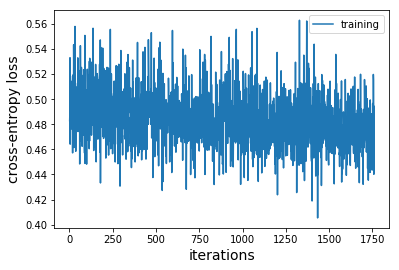

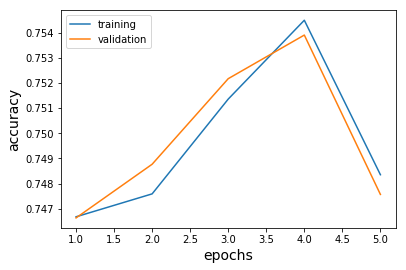

In [166]:
trainingMetrics(history)

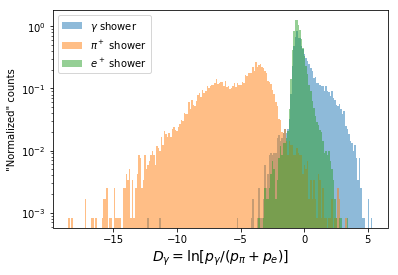

../plottingFcts.py:229: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


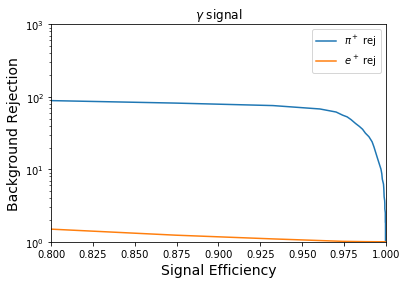

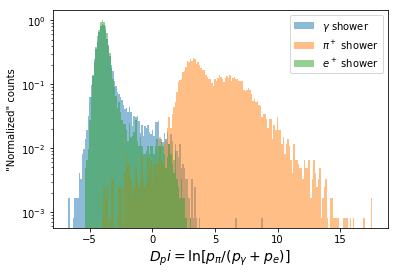

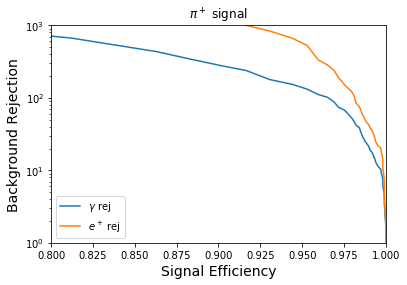

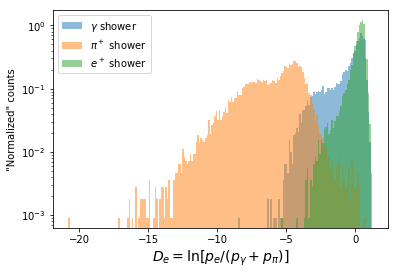

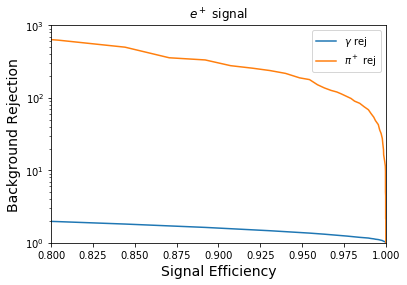

In [167]:
particles = ['gamma','pi','e']

for node in range(3):
    g_eff, pi_eff, e_eff = sigBkgEff(myModel, loader_val, node)
    mTag = '{}-sig_{}'.format(particles[node], myModel.modelName)
    
    # Plot the ROC curve using node as the signal and the other two as the bkg
    if node == 0:
        plotROC([g_eff, g_eff], [pi_eff, e_eff], ['$\pi^+$ rej', '$e^+$ rej'], title='$\gamma$ signal', tag=mTag)
    if node == 1:
        plotROC([pi_eff, pi_eff], [g_eff, e_eff], ['$\gamma$ rej', '$e^+$ rej'], title='$\pi^+$ signal', tag=mTag)
    elif node == 2:
        plotROC([e_eff, e_eff], [g_eff, pi_eff], ['$\gamma$ rej', '$\pi^+$ rej'], title='$e^+$ signal', tag=mTag)
        

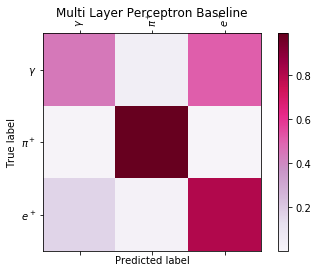

In [168]:
plotConfusion(myModel, loader_val, title="Multi Layer Perceptron Baseline")

### Goals:
- Print the number of parameters for each model
- Just change hyperparameters (by hand) to get more intuition for the problem
- Maybe try downsampling to (6,3) instead of upsampling to (12,12)
- Could try adding a learning rate scheduler
- Try changing the optimizer

# Recurrent CNN

- Apply three 2d convolutions to get a fixed size for the image vector!